# BloodMNIST Classification and Analysis

## 1. Introduction
This notebook focuses on the analysis and classification of the BloodMNIST dataset. The dataset contains images of blood cell types, and we explore various machine learning models, including Convolutional Neural Networks (CNN), Long Short-Term Memory (LSTM) networks, RandomForestClassifier, and DenseNet. The goal is to showcase different approaches to image classification and provide insights into model performance.

## 2. Dataset Download and Exploration
We begin by downloading the BloodMNIST dataset and exploring its contents.


In [8]:
import numpy as np
import urllib.request
import os

# Download the dataset to the local folder
if not os.path.isfile('./bloodmnist.npz'):
    urllib.request.urlretrieve('https://zenodo.org/record/6496656/files/bloodmnist.npz?download=1', 'bloodmnist.npz')

# Load the compressed numpy array file
dataset = np.load('./bloodmnist.npz')

# The loaded dataset contains each array internally
for key in dataset.keys():
    print(key, dataset[key].shape, dataset[key].dtype)

print(dataset['train_images'].shape)


train_images (11959, 28, 28, 3) uint8
train_labels (11959, 1) uint8
val_images (1712, 28, 28, 3) uint8
val_labels (1712, 1) uint8
test_images (3421, 28, 28, 3) uint8
test_labels (3421, 1) uint8
(11959, 28, 28, 3)


# 3. CNN Classification
## 3.1 Data Preprocessing
We preprocess the data and labels for CNN classification.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import cv2

# Constants
num_classes = 10
image_size = 28

# Extracting data and labels
X_train = dataset['train_images']
y_train = dataset['train_labels']
X_val = dataset['val_images']
y_val = dataset['val_labels']
X_test = dataset['test_images']
y_test = dataset['test_labels']

def rgb_to_gray(images):
    gray_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    return np.array(gray_images)

def preprocess_data(images, labels, num_classes, image_size):
    images_gray = rgb_to_gray(images).reshape(-1, image_size, image_size, 1).astype('float32') / 255.0
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    return images_gray, labels_one_hot

# Preprocess the images and labels
X_train, y_train = preprocess_data(dataset['train_images'], dataset['train_labels'], num_classes, image_size)
X_test, y_test = preprocess_data(dataset['test_images'], dataset['test_labels'], num_classes, image_size)
X_val, y_val = preprocess_data(dataset['val_images'], dataset['val_labels'], num_classes, image_size)


## 3.2 CNN Model Definition and Training
We define a CNN model using the Functional API and train it.

In [14]:
# Define the CNN model using Functional API
inputs = layers.Input(shape=(image_size, image_size, 1))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/30
374/374 [==============================] - 14s 34ms/step - loss: 1.1094 - accuracy: 0.6046 - val_loss: 0.7942 - val_accuracy: 0.7284
Epoch 2/30
374/374 [==============================] - 12s 31ms/step - loss: 0.7664 - accuracy: 0.7257 - val_loss: 0.6776 - val_accuracy: 0.7611
Epoch 3/30
374/374 [==============================] - 12s 31ms/step - loss: 0.6675 - accuracy: 0.7588 - val_loss: 0.5838 - val_accuracy: 0.7810
Epoch 4/30
374/374 [==============================] - 12s 31ms/step - loss: 0.5842 - accuracy: 0.7932 - val_loss: 0.6387 - val_accuracy: 0.7687
Epoch 5/30
374/374 [==============================] - 12s 32ms/step - loss: 0.5431 - accuracy: 0.8048 - val_loss: 0.5243 - val_accuracy: 0.8236
Epoch 6/30
374/374 [==============================] - 11s 30ms/step - loss: 0.4972 - accuracy: 0.8216 - val_loss: 0.4897 - val_accuracy: 0.8341
Epoch 7/30
374/374 [==============================] - 12s 31ms/step - loss: 0.4594 - accuracy: 0.8344 - val_loss: 0.4490 - val_accuracy:

## 3.3 Model Evaluation and Visualization
We evaluate the CNN model on the test set and visualize the results.

107/107 [==============================] - 1s 8ms/step - loss: 0.3811 - accuracy: 0.8787
Test Accuracy: 0.8787
Test Loss: 0.3811
107/107 [==============================] - 1s 8ms/step


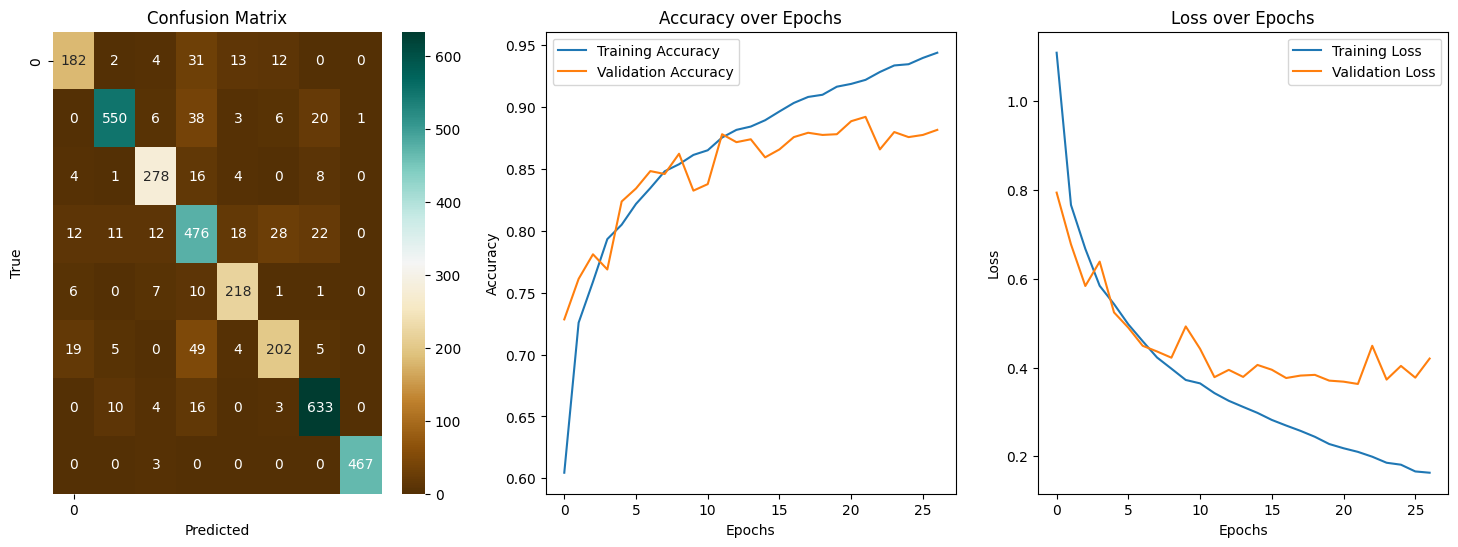

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print test accuracy and loss
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Predict the labels for the test set
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix, accuracy, and loss on one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'BrBG', xticklabels=num_classes, yticklabels=num_classes, ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix')

# Accuracy over epochs
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Loss over epochs
ax3.plot(history.history['loss'], label='Training Loss')
ax3.plot(history.history['val_loss'], label='Validation Loss')
ax3.set_title('Loss over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()

plt.show()


# 4. LSTM Classification
## 4.1 Data Preprocessing for LSTM and Training
We define an LSTM model and train it.

In [17]:
# Extracting data and labels
X_train = dataset['train_images']
y_train = dataset['train_labels']
X_val = dataset['val_images']
y_val = dataset['val_labels']
X_test = dataset['test_images']
y_test = dataset['test_labels']

# Assuming images are resized to a fixed size, e.g., (28, 28)
img_height, img_width = 28, 28
num_classes = 10

# Convert RGB images to grayscale
def rgb_to_gray(images):
    gray_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images]
    return np.array(gray_images)

# Modularize the preprocessing steps
def preprocess_data(images, labels, num_classes, img_height, img_width):
    images_gray = rgb_to_gray(images).astype('float32') / 255.0
    images_reshaped = images_gray.reshape(-1, img_height, img_width).astype('float32')
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    return images_reshaped, labels_one_hot

# Preprocess the images and labels
X_train, y_train = preprocess_data(dataset['train_images'], dataset['train_labels'], num_classes, img_height, img_width)
X_test, y_test = preprocess_data(dataset['test_images'], dataset['test_labels'], num_classes, img_height, img_width)
X_val, y_val = preprocess_data(dataset['val_images'], dataset['val_labels'], num_classes, img_height, img_width)

# Define the LSTM model with a BatchNormalization layer
model = keras.Sequential([
    layers.BatchNormalization(input_shape=(img_height, img_width)),
    layers.LSTM(128, activation='relu', return_sequences=True),
    layers.LSTM(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])


Epoch 1/30
374/374 [==============================] - 28s 65ms/step - loss: 1.1144 - accuracy: 0.5894 - val_loss: 0.8831 - val_accuracy: 0.6676
Epoch 2/30
374/374 [==============================] - 24s 65ms/step - loss: 0.7813 - accuracy: 0.7086 - val_loss: 0.7100 - val_accuracy: 0.7418
Epoch 3/30
374/374 [==============================] - 23s 63ms/step - loss: 0.7003 - accuracy: 0.7476 - val_loss: 0.6104 - val_accuracy: 0.7658
Epoch 4/30
374/374 [==============================] - 24s 63ms/step - loss: 0.6120 - accuracy: 0.7739 - val_loss: 0.5630 - val_accuracy: 0.7938
Epoch 5/30
374/374 [==============================] - 24s 64ms/step - loss: 0.5462 - accuracy: 0.7989 - val_loss: 0.5291 - val_accuracy: 0.8008
Epoch 6/30
374/374 [==============================] - 24s 63ms/step - loss: 0.5008 - accuracy: 0.8151 - val_loss: 0.5043 - val_accuracy: 0.8160
Epoch 7/30
374/374 [==============================] - 22s 60ms/step - loss: 0.5033 - accuracy: 0.8195 - val_loss: 0.5006 - val_accuracy:

# 4.3 Model Evaluation and Visualization for LSTM
We evaluate the LSTM model on the test set and visualize the results.

107/107 [==============================] - 2s 21ms/step - loss: 0.4289 - accuracy: 0.8536
Test Accuracy: 0.8536
Test Loss: 0.4289
107/107 [==============================] - 3s 23ms/step


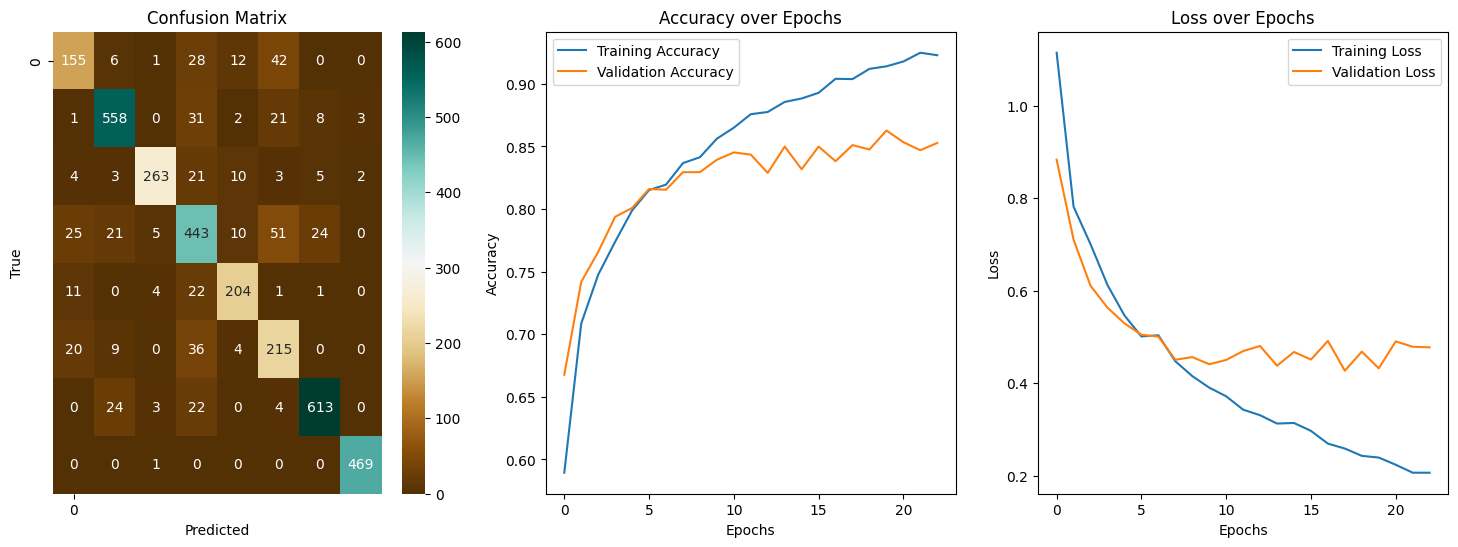

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print test accuracy and loss
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Predict the labels for the test set
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix, accuracy, and loss on one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'BrBG', xticklabels=num_classes, yticklabels=num_classes, ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix')

# Accuracy over epochs
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Loss over epochs
ax3.plot(history.history['loss'], label='Training Loss')
ax3.plot(history.history['val_loss'], label='Validation Loss')
ax3.set_title('Loss over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()

plt.show()


# 5. RandomForestClassifier
## 5.1 Data Preprocessing for RandomForestClassifier Model and Training
We train the RandomForestClassifier model and evaluate its performance.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Convert RGB images to grayscale
def rgb_to_gray(images):
    gray_images = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray_images.append(gray_img)
    return np.array(gray_images)

# Preprocess the images and labels
train_images = rgb_to_gray(dataset['train_images']).astype('float32') / 255.0
test_images = rgb_to_gray(dataset['test_images']).astype('float32') / 255.0

num_classes = 128
train_labels = dataset['train_labels']
test_labels = dataset['test_labels']

# Flatten images
img_height, img_width = 28, 28
train_images = train_images.reshape(-1, img_height * img_width).astype('float32')
test_images = test_images.reshape(-1, img_height * img_width).astype('float32')

# Create and train RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=54)
model.fit(train_images, train_labels)


<ipython-input-20-1785c8cda40a>:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_images, train_labels)


RandomForestClassifier(random_state=54)

## 5.2 Model Evaluation and Visualization for RandomForest
We evaluate the RandomForest model on the test set and visualize the results.

Test Accuracy: 0.8129
Accuracy: 81.29%
Error Rate: 18.71%


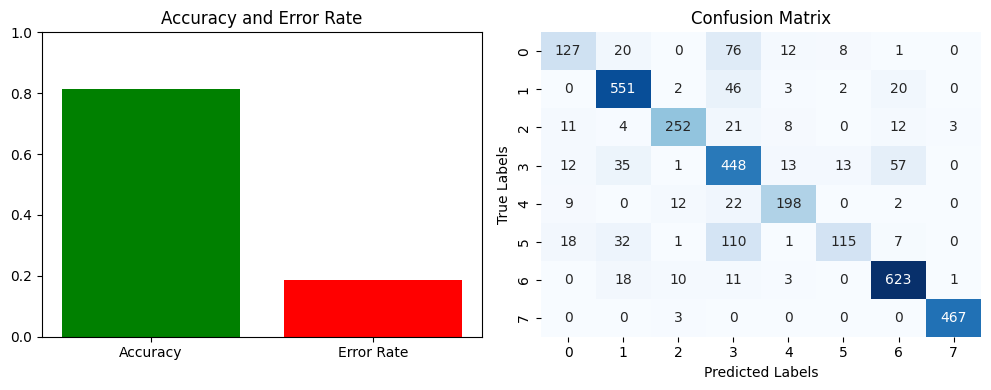

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Make predictions on the test set
predictions = model.predict(test_images)

# Evaluate the model
test_accuracy = accuracy_score(test_labels, predictions)

# Print test accuracy
print(f'Test Accuracy: {test_accuracy:.4f}')
# Plot for RandomForestClassifier

# Make predictions on the test set
predictions = model.predict(test_images)
# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate error rate
error_rate = 1 - accuracy
print(f'Error Rate: {error_rate * 100:.2f}%')

# Create a confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

# Plot Accuracy and Error Rate
plt.figure(figsize=(15, 4))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.bar(['Accuracy', 'Error Rate'], [accuracy, error_rate], color=['green', 'red'])
plt.ylim(0, 1)
plt.title('Accuracy and Error Rate')

# Plot Confusion Matrix
plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plots
plt.tight_layout()
plt.show()


# 6. DenseNet Classification
## 6.1 Data Preprocessing for DenseNet and Training
We define a DenseNet model and train it.

In [23]:
# Function to convert RGB images to grayscale
def rgb_to_gray(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

# Function to preprocess data
def preprocess_data(images, labels, num_classes, img_height, img_width):
    images_gray = rgb_to_gray(images).astype('float32') / 255.0
    images_gray = images_gray.reshape(-1, img_height, img_width, 1)
    labels_one_hot = to_categorical(labels, num_classes=num_classes)
    return images_gray, labels_one_hot

# Assuming images are resized to a fixed size, e.g., (28, 28)
img_height, img_width = 28, 28
num_classes = 10

# Preprocess the images and labels
images, labels = preprocess_data(dataset['train_images'], dataset['train_labels'], num_classes, img_height, img_width)

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=54)

# Define DenseNet model
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),

    # Dense Block 1
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.MaxPooling2D(pool_size=(2, 2)),

    # Transition Layer 1
    layers.Conv2D(128, kernel_size=(1, 1), activation='relu'),
    layers.BatchNormalization(),

    # Dense Block 2
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),

    # Fully Connected Layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implement early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_images, train_labels, epochs=30, validation_data=(test_images, test_labels), callbacks=[early_stopping])


Epoch 1/30
299/299 [==============================] - 60s 189ms/step - loss: 0.7149 - accuracy: 0.7432 - val_loss: 5.8806 - val_accuracy: 0.1329
Epoch 2/30
299/299 [==============================] - 55s 185ms/step - loss: 0.4890 - accuracy: 0.8259 - val_loss: 0.8271 - val_accuracy: 0.7542
Epoch 3/30
299/299 [==============================] - 54s 182ms/step - loss: 0.4268 - accuracy: 0.8465 - val_loss: 1.3550 - val_accuracy: 0.6309
Epoch 4/30
299/299 [==============================] - 55s 184ms/step - loss: 0.3907 - accuracy: 0.8608 - val_loss: 0.5717 - val_accuracy: 0.8056
Epoch 5/30
299/299 [==============================] - 56s 189ms/step - loss: 0.3479 - accuracy: 0.8783 - val_loss: 1.5255 - val_accuracy: 0.5974
Epoch 6/30
299/299 [==============================] - 56s 188ms/step - loss: 0.3330 - accuracy: 0.8833 - val_loss: 0.9771 - val_accuracy: 0.7533
Epoch 7/30
299/299 [==============================] - 56s 187ms/step - loss: 0.2924 - accuracy: 0.8997 - val_loss: 0.7848 - val_ac

## 6.2 Model Evaluation and Visualization for DenseNet
We evaluate the DenseNet model on the test set and visualize the results.

75/75 [==============================] - 3s 40ms/step - loss: 0.5717 - accuracy: 0.8056
Test Accuracy: 0.8056
Test Loss: 0.5717
107/107 [==============================] - 5s 40ms/step


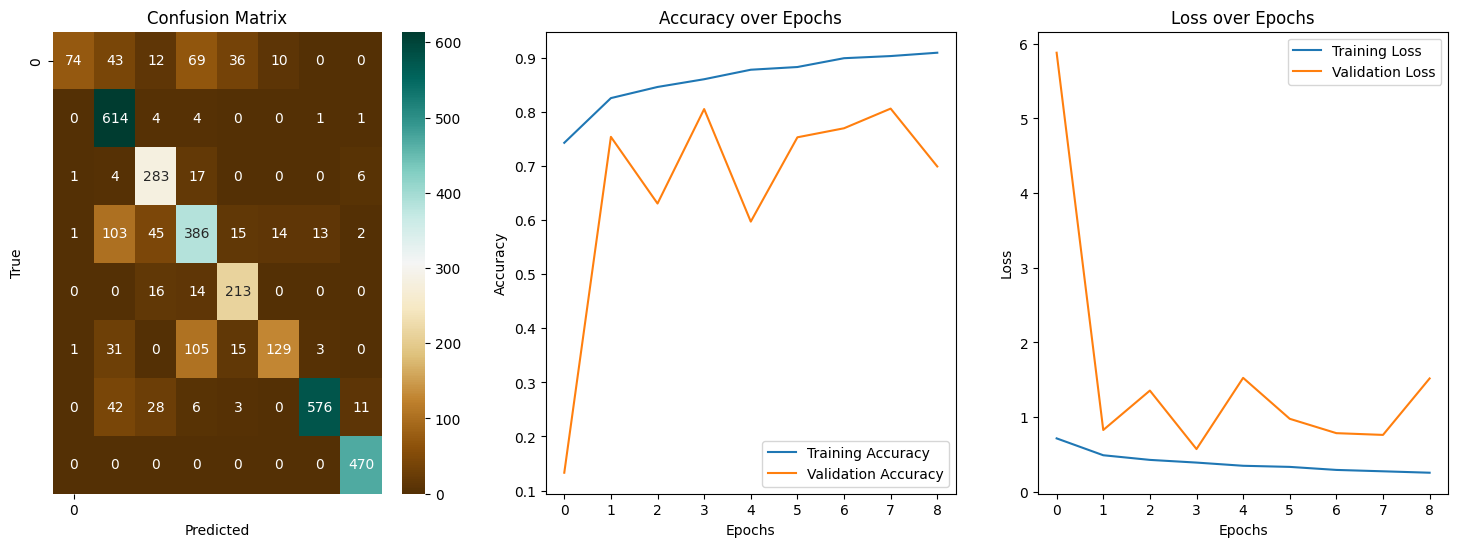

In [24]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Print test accuracy and loss
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Predict the labels for the test set
predicted_labels = model.predict(X_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix, accuracy, and loss on one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'BrBG', xticklabels=num_classes, yticklabels=num_classes, ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix')

# Accuracy over epochs
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Loss over epochs
ax3.plot(history.history['loss'], label='Training Loss')
ax3.plot(history.history['val_loss'], label='Validation Loss')
ax3.set_title('Loss over Epochs')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.legend()

plt.show()
